# Neural Networks From Scratch

In [1]:
import pandas as pd
import time
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path

save_dir = Path("../data/mnist_784/")
download_dataset = False
if download_dataset:
    x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
    x = (x/255).astype('float32')
    y = to_categorical(y)

    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

    x_train.to_parquet(save_dir / "x_train.parquet")
    x_val.to_parquet(save_dir / "x_val.parquet")
    np.save(save_dir / "y_train.npy", y_train)
    np.save(save_dir / "y_val.npy", y_val)
else:
    x_train= pd.read_parquet(save_dir / "x_train.parquet").to_numpy()
    x_val = pd.read_parquet(save_dir / "x_val.parquet")
    y_train = np.load(save_dir / "y_train.npy")
    y_val = np.load(save_dir / "y_val.npy")

In [2]:
print("X:" , x_train.shape)
print("Y:", y_train.shape)

X: (59500, 784)
Y: (59500, 10)


In [3]:
def compute_accuracy(model, x_val, y_val):
    """
    This function does a forward pass of x, then checks if the indices
    of the maximum value in the output equals the indices in the label
    y. Then it sums over each prediction and calculates the accuracy.
    """
    x_val = x_val.to_numpy()

    output = model.forward(x_val)
    pred = np.argmax(output, axis=-1)
    target = np.argmax(y_val, axis=-1)
    return np.mean(pred == target)

### Results

In [4]:
from minMLP.layers import MLP
from minMLP.functional import mse_loss, mse_loss_grad
from minMLP.optimizer import SGD


In [9]:
EPOCHS = 20
BATCH_SIZE = 64
dnn = MLP(sizes=[784, 100, 10])
optimizer = SGD(dnn.parameters(), lr=0.05)

start_time = time.time()
dnn.train()
for iteration in range(EPOCHS):
    accuracy = compute_accuracy(dnn, x_val, y_val)
    print(
        "Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%".format(
            iteration, time.time() - start_time, accuracy * 100
        )
    )
    for j in range(0, len(x_train), BATCH_SIZE):
        x = x_train[j : min(len(x_train), j + BATCH_SIZE), ...]
        y = y_train[j : min(len(x_train), j + BATCH_SIZE)]

        output = dnn.forward(x)
        loss = mse_loss(output, y)
        dout = mse_loss_grad(output, y)

        dnn.zero_grad()
        dnn.backward(dout)
        optimizer.step()


accuracy = compute_accuracy(dnn, x_val, y_val)
print(
    "Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%".format(
        EPOCHS, time.time() - start_time, accuracy * 100
    )
)


Epoch: 0, Time Spent: 0.05s, Accuracy: 13.64%
Epoch: 1, Time Spent: 2.82s, Accuracy: 25.63%
Epoch: 2, Time Spent: 4.86s, Accuracy: 28.43%
Epoch: 3, Time Spent: 6.93s, Accuracy: 37.38%
Epoch: 4, Time Spent: 9.03s, Accuracy: 47.39%
Epoch: 5, Time Spent: 11.26s, Accuracy: 51.27%
Epoch: 6, Time Spent: 13.41s, Accuracy: 53.45%
Epoch: 7, Time Spent: 15.68s, Accuracy: 54.75%
Epoch: 8, Time Spent: 17.87s, Accuracy: 55.76%
Epoch: 9, Time Spent: 20.32s, Accuracy: 56.62%
Epoch: 10, Time Spent: 22.99s, Accuracy: 57.47%
Epoch: 11, Time Spent: 25.23s, Accuracy: 60.67%
Epoch: 12, Time Spent: 27.42s, Accuracy: 63.51%
Epoch: 13, Time Spent: 29.59s, Accuracy: 65.35%
Epoch: 14, Time Spent: 31.72s, Accuracy: 66.25%
Epoch: 15, Time Spent: 33.92s, Accuracy: 66.86%
Epoch: 16, Time Spent: 36.06s, Accuracy: 67.45%
Epoch: 17, Time Spent: 38.58s, Accuracy: 67.96%
Epoch: 18, Time Spent: 40.79s, Accuracy: 68.27%
Epoch: 19, Time Spent: 43.04s, Accuracy: 69.01%
Epoch: 20, Time Spent: 45.20s, Accuracy: 70.27%


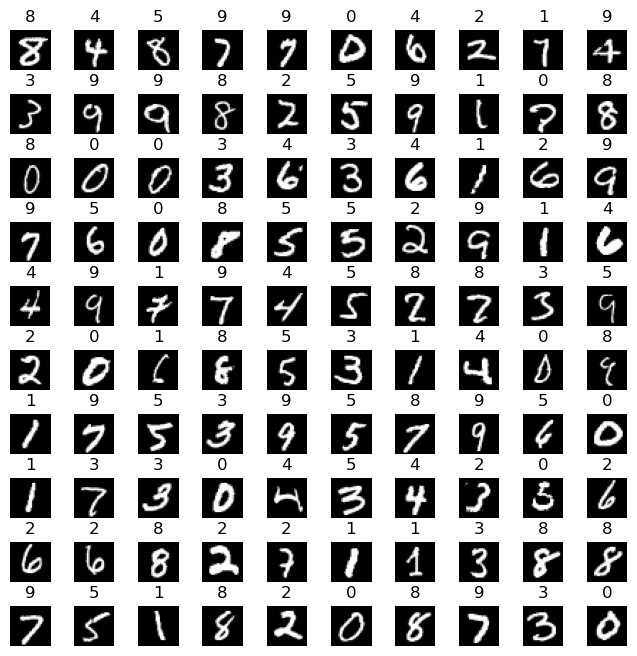

In [10]:
dnn.eval()
# plot the MNIST images in a grid, with the prediction for each image as the caption
fig, ax = plt.subplots(10, 10, figsize=(8, 8))
# add some space between the images
fig.subplots_adjust(hspace=0.6, wspace=0.5)
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(x_val.iloc[i*10+j].to_numpy().reshape(28, 28), cmap='gray')
        ax[i, j].set_title(np.argmax(dnn.forward(x_val.iloc[i*10+j])), fontsize=12)
        ax[i, j].axis('off')